In [10]:
# import the necessary packages
import numpy as np
import imutils
import cv2
import argparse

# stuff just for IPython
from IPython.display import display
from IPython.display import Image
from matplotlib import pyplot as plt

### Stitcher class

This is a class provided by OpenCV that achieves basic left-to-right stitching.

In [11]:
class Stitcher:
	def __init__(self):
		# determine if we are using OpenCV v3.X
		self.isv3 = imutils.is_cv3()

	def stitch(self, images, ratio=0.75, reprojThresh=4.0,
		showMatches=False):
		# unpack the images, then detect keypoints and extract
		# local invariant descriptors from them
		(imageB, imageA) = images
		(kpsA, featuresA) = self.detectAndDescribe(imageA)
		(kpsB, featuresB) = self.detectAndDescribe(imageB)

		# match features between the two images
		M = self.matchKeypoints(kpsA, kpsB,
			featuresA, featuresB, ratio, reprojThresh)

		# if the match is None, then there aren't enough matched
		# keypoints to create a panorama
		if M is None:
			return None

		# otherwise, apply a perspective warp to stitch the images
		# together
		(matches, H, status) = M
		result = cv2.warpPerspective(imageA, H,
			(imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
		result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB

		# check to see if the keypoint matches should be visualized
		if showMatches:
			vis = self.drawMatches(imageA, imageB, kpsA, kpsB, matches,
				status)

			# return a tuple of the stitched image and the
			# visualization
			return (result, vis)

		# return the stitched image
		return result

	def detectAndDescribe(self, image):
		# convert the image to grayscale
		gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

		# check to see if we are using OpenCV 3.X
		if self.isv3:
			# detect and extract features from the image
			descriptor = cv2.xfeatures2d.SIFT_create()
			(kps, features) = descriptor.detectAndCompute(image, None)

		# otherwise, we are using OpenCV 2.4.X
		else:
			# detect keypoints in the image
			detector = cv2.FeatureDetector_create("SIFT")
			kps = detector.detect(gray)

			# extract features from the image
			extractor = cv2.DescriptorExtractor_create("SIFT")
			(kps, features) = extractor.compute(gray, kps)

		# convert the keypoints from KeyPoint objects to NumPy
		# arrays
		kps = np.float32([kp.pt for kp in kps])

		# return a tuple of keypoints and features
		return (kps, features)

	def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB,
		ratio, reprojThresh):
		# compute the raw matches and initialize the list of actual
		# matches
		matcher = cv2.DescriptorMatcher_create("BruteForce")
		rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
		matches = []

		# loop over the raw matches
		for m in rawMatches:
			# ensure the distance is within a certain ratio of each
			# other (i.e. Lowe's ratio test)
			if len(m) == 2 and m[0].distance < m[1].distance * ratio:
				matches.append((m[0].trainIdx, m[0].queryIdx))

		# computing a homography requires at least 4 matches
		if len(matches) > 4:
			# construct the two sets of points
			ptsA = np.float32([kpsA[i] for (_, i) in matches])
			ptsB = np.float32([kpsB[i] for (i, _) in matches])

			# compute the homography between the two sets of points
			(H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
				reprojThresh)

			# return the matches along with the homograpy matrix
			# and status of each matched point
			return (matches, H, status)

		# otherwise, no homograpy could be computed
		return None

	def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
		# initialize the output visualization image
		(hA, wA) = imageA.shape[:2]
		(hB, wB) = imageB.shape[:2]
		vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
		vis[0:hA, 0:wA] = imageA
		vis[0:hB, wA:] = imageB

		# loop over the matches
		for ((trainIdx, queryIdx), s) in zip(matches, status):
			# only process the match if the keypoint was successfully
			# matched
			if s == 1:
				# draw the match
				ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
				ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
				cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

		# return the visualization
		return vis

TypeError: Image data cannot be converted to float

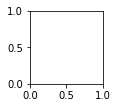

In [12]:
# test sequence 1: load images #
imageA = cv2.imread('pano1_0008.jpg')
imageB = cv2.imread('pano1_0009.jpg')
imageC = cv2.imread('pano1_0010.jpg')
imageD = cv2.imread('pano1_0011.jpg')

plt.subplot(1,4,1)
plt.imshow(imageA)
plt.subplot(1,4,2)
plt.imshow(imageB)
plt.subplot(1,4,3)
plt.imshow(imageC)
plt.subplot(1,4,4)
plt.imshow(imageD)
plt.show()

In [13]:
# test sequence 2: run stitcher on two images #

stitcher = Stitcher()
(result,vis) = stitcher.stitch([imageB,imageA],showMatches = True)

plt.subplot(1,2,1)
plt.imshow(vis)
plt.title("Keypoint Matches")
plt.subplot(1,2,2)
plt.imshow(result)
plt.title("Result")
plt.show()

error: C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:11111: error: (-215) scn == 3 || scn == 4 in function cv::cvtColor


In [14]:
# note that the order does appear to matter.
# trying to reverse the order of the inputs into the stitcher
# gets you something like this

(result,vis) = stitcher.stitch([imageA,imageB],showMatches = True)

plt.subplot(1,2,1)
plt.imshow(vis)
plt.title("Keypoint Matches")
plt.subplot(1,2,2)
plt.imshow(result)
plt.title("Result")
plt.show()
# Note that the result obtained is not a stitched image.

# this is just to put things back as they were after the demonstration
(result,vis) = stitcher.stitch([imageB,imageA],showMatches = True)

error: C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:11111: error: (-215) scn == 3 || scn == 4 in function cv::cvtColor


In [15]:
# now we need to start stitching multiple images together
current_pano = result
(result,vis) = stitcher.stitch([imageC,current_pano],showMatches = True)

plt.subplot(1,2,1)
plt.imshow(vis)
plt.title("Keypoint Matches")
plt.subplot(1,2,2)
plt.imshow(result)
plt.title("Result")
plt.show()

current_pano = result
(result,vis) = stitcher.stitch([imageD,current_pano],showMatches = True)

plt.subplot(1,2,1)
plt.imshow(vis)
plt.title("Keypoint Matches")
plt.subplot(1,2,2)
plt.imshow(result)
plt.title("Result")
plt.show()

NameError: name 'result' is not defined

### Attempting to Stitch Horizontally and Vertically.

Now that we more or less understand horizontal stitching, we need a method of doing this in x and y. I generated the following dataset to test methods.



In [16]:
import helperfuncs
import imutils
import cv2

# This will display all of the images we're going to use
# for this experiment in order. 
i = 1
for x in range(0,11):
    for y in range (0,3):
        filename = helperfuncs.getFilename(x,y)
        img = cv2.imread(filename)
        plt.subplot(3,11,i)
        plt.imshow(img)
        i = i+1
plt.show()

ModuleNotFoundError: No module named 'helperfuncs'

In [17]:
from scipy.ndimage import rotate
import helperfuncs
import cv2

# Now let's go ahead and perform stitching. First, we'll
# stitch images vertically by rotating them and stitching
# them using the horizontal left-right method.

# First, experiment with performing the procedure manually.
img0 = rotate(cv2.resize(cv2.imread(helperfuncs.getFilename(0,0)),(0,0),fx=0.4,fy=0.4),270)
img1 = rotate(cv2.resize(cv2.imread(helperfuncs.getFilename(0,1)),(0,0),fx=0.4,fy=0.4),270)
img2 = rotate(cv2.resize(cv2.imread(helperfuncs.getFilename(0,2)),(0,0),fx=0.4,fy=0.4),270)
plt.subplot(1,3,1)
plt.imshow(img0)
plt.subplot(1,3,2)
plt.imshow(img1)
plt.subplot(1,3,3)
plt.imshow(img2)
plt.show()
result1 = stitcher.stitch([img2,img1],showMatches = False)
result = stitcher.stitch([result1,img0],showMatches = False)
resultA = rotate(result,90)
plt.imshow(resultA)

img0 = rotate(cv2.resize(cv2.imread(helperfuncs.getFilename(1,0)),(0,0),fx=0.4,fy=0.4),270)
img1 = rotate(cv2.resize(cv2.imread(helperfuncs.getFilename(1,1)),(0,0),fx=0.4,fy=0.4),270)
img2 = rotate(cv2.resize(cv2.imread(helperfuncs.getFilename(1,2)),(0,0),fx=0.4,fy=0.4),270)
plt.subplot(1,3,1)
plt.imshow(img0)
plt.subplot(1,3,2)
plt.imshow(img1)
plt.subplot(1,3,3)
plt.imshow(img2)
plt.show()
result1 = stitcher.stitch([img2,img1],showMatches = False)
result = stitcher.stitch([result1,img0],showMatches = False)
resultB = rotate(result,90)
plt.imshow(resultB)

result_final = stitcher.stitch([resultA,resultB],showMatches = False)
plt.imshow(result_final)


ModuleNotFoundError: No module named 'helperfuncs'

In [18]:
from scipy.ndimage import rotate
import helperfuncs
import cv2

# The test above was marginally successful. Let's attempt to loop through.

for x in range(0,11):
    print('Current Iteration: ' + str(x))
    if x==0:
        img0 = rotate(cv2.resize(cv2.imread(helperfuncs.getFilename(0,0)),(0,0),fx=0.4,fy=0.4),270)
        img1 = rotate(cv2.resize(cv2.imread(helperfuncs.getFilename(0,1)),(0,0),fx=0.4,fy=0.4),270)
        img2 = rotate(cv2.resize(cv2.imread(helperfuncs.getFilename(0,2)),(0,0),fx=0.4,fy=0.4),270)
        result1 = stitcher.stitch([img2,img1],showMatches = False)
        result = stitcher.stitch([result1,img0],showMatches = False)
        prevResult = rotate(result,90)
    else:
        img0 = rotate(cv2.resize(cv2.imread(helperfuncs.getFilename(x,0)),fx=0.4,fy=0.4),270)
        img1 = rotate(cv2.resize(cv2.imread(helperfuncs.getFilename(x,1)),fx=0.4,fy=0.4),270)
        img2 = rotate(cv2.resize(cv2.imread(helperfuncs.getFilename(x,2)),fx=0.4,fy=0.4),270)
        result1 = stitcher.stitch([img2,img1],showMatches = False)
        result = stitcher.stitch([result1,img0],showMatches = False)
        result = rotate(result,90)
        finalresult = stitcher.stitch([prevResult,result],showMatches = False)
        prevResult = finalresult
        plt.imshow(finalresult)
        plt.show()

ModuleNotFoundError: No module named 'helperfuncs'